To get around Colab's Markdown display issues and potential issues with the `plotly` library, the questions in this problem set are rendered in code blocks. Simply re-run the associated code block to re-render the question, if needed.

As a benefit, the questions will come with occasional hints about your programming environment.

Make sure the file `PS7.py` is in the same directory as this notebook. This file contains the question definitions and helper functions for this dataset. Do not modify this file.

If you do use Google Colab, make the notebook editable for the TAs, and provide the share link to the notebook below. Please share the notebook you worked on, and not a copy of it.

**Make sure the 'notify' checkbox is <i>not</i> checked when sharing the notebook.**

--------


link to Colab: https://colab.research.google.com/github/emilklo/amlberkeley/blob/main/PS7/INFO251_S25_PS7.ipynb#scrollTo=VtHeSO2bqyuP

(leave blank if not using Colab)

In [1]:
# download necessary packages
%pip install sentence-transformers plotly datasets transformers "transformers[torch]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import seaborn as sns
sns.set_style()

import torch.nn as nn
import torch.nn.functional as F

import plotly.express as px

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
!wget https://raw.githubusercontent.com/emilklo/amlberkeley/main/PS7/PS7.py
!pip install datasets


import PS7

--2025-05-05 18:30:11--  https://raw.githubusercontent.com/emilklo/amlberkeley/main/PS7/PS7.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22763 (22K) [text/plain]
Saving to: ‘PS7.py’

PS7.py              100%[===================>]  22.23K  --.-KB/s    in 0.001s  

2025-05-05 18:30:11 (37.5 MB/s) - ‘PS7.py’ saved [22763/22763]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec

<IPython.core.display.Javascript object>

In [3]:
PS7.intro()

<IPython.core.display.Javascript object>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<IPython.core.display.Javascript object>

In [5]:
PS7.q0()

<IPython.core.display.Javascript object>

<span style="color:#FDB515"><b>Question 0 - your answers here</b></span>



In [6]:
PS7.part1()

<IPython.core.display.Javascript object>

In [7]:
PS7.q1()

<IPython.core.display.Javascript object>

In [8]:
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(
    subset='all', remove=('headers', 'footers', 'quotes')
)

# your code here
print(f"Number of documents: {len(newsgroups.data)}")
print(f"Categories: {newsgroups.target_names}")
print("Example document:")
print(newsgroups.data[0])
print(f"Label: {newsgroups.target_names[newsgroups.target[0]]}")


Number of documents: 18846
Categories: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
Example document:


I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the

<IPython.core.display.Javascript object>

<span style="color:#FDB515"><b>Question 1 - your answers here</b></span>

a) The data is a collection of about 19,000 newsgroup posts from 20 online discussion topics. Each data point is a newsgroup post text document. Every document is labeled with one of 20 newsgroup categories.

b) For each text post, the prediction target is the category it belongs to.
This is represented by the target field in the dataset as an integer which maps to the category in target_names. There are 20 classes to predict.

c) No, newsgroups["data"] cannot be passed directly to a LogisticRegression method. newsgroups["data"] is a list of raw text strings, and LogisticRegression expects numerical input.



In [9]:
PS7.q2()

<IPython.core.display.Javascript object>

In [10]:
from sklearn.datasets import fetch_20newsgroups_vectorized

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

subset_size = 2000

# your code here
vectorized = fetch_20newsgroups_vectorized(subset='all')
X_tfidf = vectorized.data[:subset_size].toarray()
print(X_tfidf.shape)

raw_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
texts = raw_data.data[:subset_size]

device = 'cpu'
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

truncation_limit = 256
num_truncated = 0
for text in texts:
    num_tokens = len(tokenizer.encode(text, truncation=True, add_special_tokens=True))
    if num_tokens >= truncation_limit:
        num_truncated += 1
print(f"Estimated number of truncated texts: {num_truncated} out of {subset_size}")


!pip install -q sentence-splitter
from sentence_splitter import SentenceSplitter
splitter = SentenceSplitter(language='en')

from tqdm import tqdm
import numpy as np

document_embeddings = []

for doc in tqdm(texts[:subset_size]):
    sentences = splitter.split(doc)
    if len(sentences) == 0:
        document_embeddings.append(np.zeros(384))
        continue
    sentence_embeddings = model.encode(sentences, batch_size=16, device=device)
    doc_embedding = np.mean(sentence_embeddings, axis=0)
    document_embeddings.append(doc_embedding)

X_embed = np.vstack(document_embeddings)
print("X_embed shape:", X_embed.shape)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(2000, 130107)
Estimated number of truncated texts: 484 out of 2000
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.9 MB/s eta 0:00:00


100%|██████████| 2000/2000 [10:22<00:00,  3.21it/s]

X_embed shape: (2000, 384)


<IPython.core.display.Javascript object>

<span style="color:#FDB515"><b>Question 2 - your answers here</b></span>

a) 484 data points out of the first 2000 run into the models truncation limit

b) (2000, 130107) and (2000, 384)

In [11]:
PS7.q3()

<IPython.core.display.Javascript object>

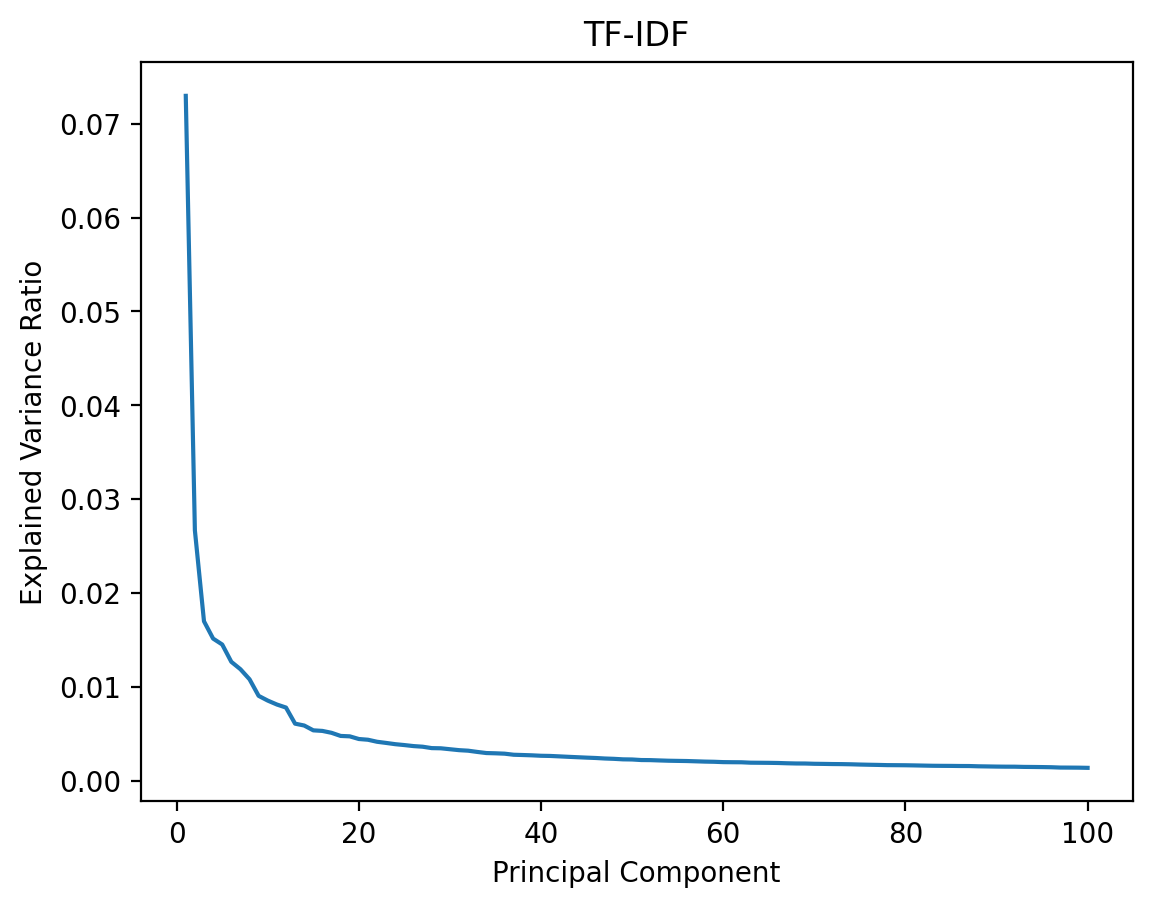

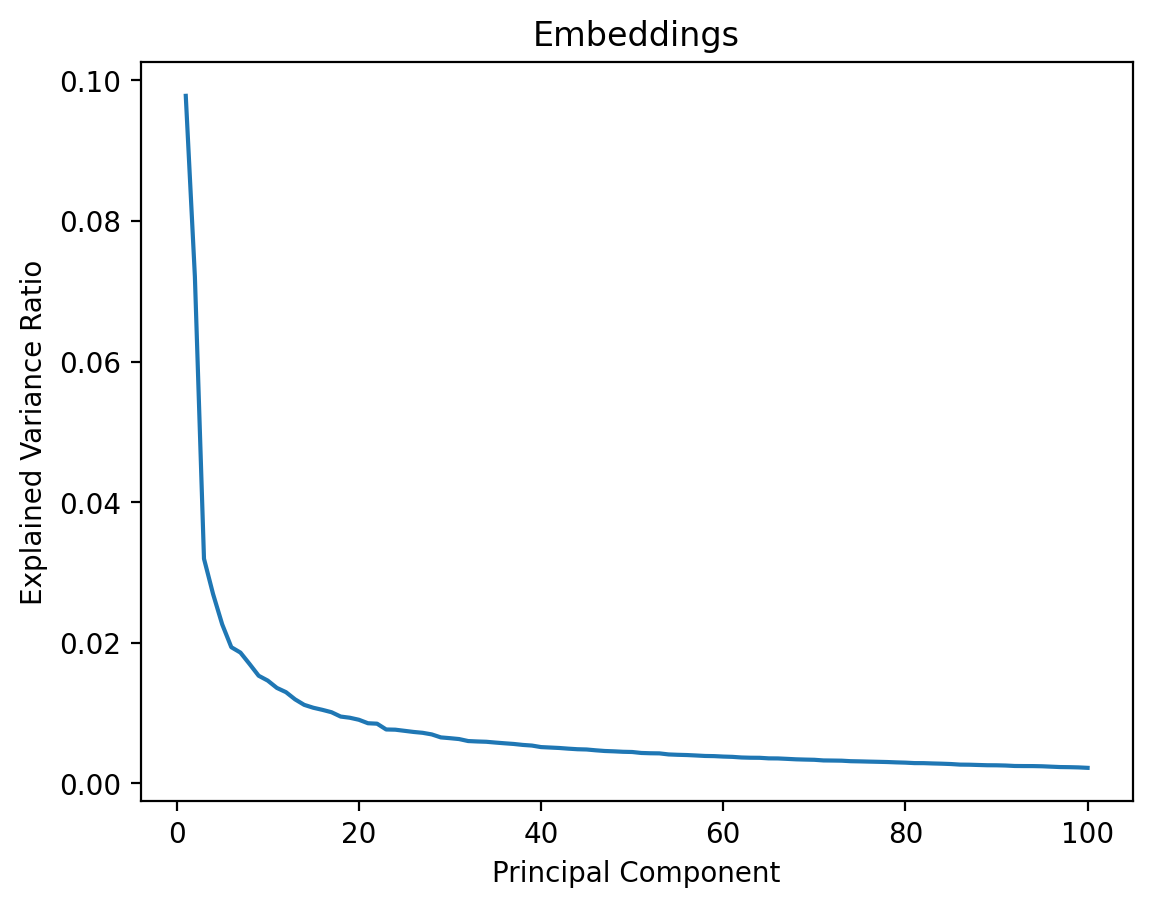

TF-IDF: Variation lost with 3 PCs: 88.34%
Embeddings:Variation lost with 3 PCs: 79.81%


<IPython.core.display.Javascript object>

In [12]:
from sklearn.decomposition import PCA

# your code here
pca_tfidf = PCA(n_components=100, svd_solver='randomized', random_state=42)
var_tfidf = pca_tfidf.fit(X_tfidf).explained_variance_ratio_

plt.figure()
plt.plot(range(1, 101), var_tfidf)
plt.title('TF-IDF')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

pca_embed = PCA(n_components=100, svd_solver='randomized', random_state=42)
var_embed = pca_embed.fit(X_embed).explained_variance_ratio_

plt.figure()
plt.plot(range(1, 101), var_embed)
plt.title('Embeddings')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# ——— Variation lost if only first 3 PCs are kept ———
loss_tfidf = 1 - var_tfidf[:3].sum()
loss_embed = 1 - var_embed[:3].sum()

print(f"TF-IDF: Variation lost with 3 PCs: {loss_tfidf:.2%}")
print(f"Embeddings:Variation lost with 3 PCs: {loss_embed:.2%}")

<span style="color:#FDB515"><b>Question 3 - your answers here</b></span>

a) For TF-IDF the curve starts above 7% for the first PC, then drops to around 2%, and continues a very gradual decreasing tail towards near 0 by PC 100. This tail shows that the tf-idf space is very high-dimensional and variance is spread over thousands of features, so each component beyond the first few captures only a tiny sliver of variance.

For the embeddings variant the first PC captures roughly 10%, the second about 3.2 %, the third 2.0 %, and then it falls off more steeply before settling into a lower tail. This indicates the 384-dimensional embedding space is much more compressible: a handful of PCs explain a sizeable chunk of the variance, unlike the tf-idf case.

b) TF-IDF
You lose about 88.3 % of the total variance, retaining only ∼11.7 % in the first three components.

Embeddings
You lose about 79.8 % of the variance, retaining ∼20.2 % in the first three components.

In [13]:
PS7.q4()

<IPython.core.display.Javascript object>

In [15]:
import plotly.express as px

# your code here
vectorized
X_tfidf
raw_data
texts
labels = raw_data.target[:subset_size]
names = raw_data.target_names

# ——— PCA to 3 dims ———
pca3_tfidf = PCA(n_components=3, random_state=42)
X_tfidf_3 = pca3_tfidf.fit_transform(X_tfidf)

pca3_embed = PCA(n_components=3, random_state=42)
X_embed_3 = pca3_embed.fit_transform(X_embed)

# ——— Verify explained‐variance sums ———
sum3_from100_tfidf = var_tfidf[:3].sum()                  # from your 100‐PC run
sum3_from3_tfidf  = pca3_tfidf.explained_variance_ratio_.sum()
print(f"TF-IDF: 100‐PC sum3 = {sum3_from100_tfidf:.4f}, 3‐PC fit sum = {sum3_from3_tfidf:.4f}")

sum3_from100_embed = var_embed[:3].sum()
sum3_from3_embed  = pca3_embed.explained_variance_ratio_.sum()
print(f"Embed: 100‐PC sum3 = {sum3_from100_embed:.4f}, 3‐PC fit sum = {sum3_from3_embed:.4f}")

# ——— 3D Scatter for TF-IDF ———
fig_tfidf = px.scatter_3d(
    x=X_tfidf_3[:,0], y=X_tfidf_3[:,1], z=X_tfidf_3[:,2],
    color=[names[i] for i in labels],
    title="3D PCA of TF-IDF Features",
    labels={'x':'PC1','y':'PC2','z':'PC3'}
)
fig_tfidf.show()

# ——— 3D Scatter for Embeddings ———
fig_embed = px.scatter_3d(
    x=X_embed_3[:,0], y=X_embed_3[:,1], z=X_embed_3[:,2],
    color=[names[i] for i in labels],
    title="3D PCA of Sentence Embeddings",
    labels={'x':'PC1','y':'PC2','z':'PC3'}
)
fig_embed.show()

TF-IDF: 100‐PC sum3 = 0.1166, 3‐PC fit sum = 0.1166
Embed: 100‐PC sum3 = 0.2019, 3‐PC fit sum = 0.2019


<IPython.core.display.Javascript object>

<span style="color:#FDB515"><b>Question 4 - your answers here</b></span>

a) Yes. When I sum the first three explained‐variance ratios from the 100-component PCA and compare it to the variance from a direct 3-component PCA, I get the exact same numbers. This shows that PCA always allocates the same total variance to the top k components whether I ask for k directly or slice them off a larger decomposition.

b) Yes. The first three eigenvectors of the covariance matrix are the same for 3 or 100.

c) For the tf-idf plot, the data points almost looks like they are scattered randomly. Light green for example, can be seen top left and right, bottom left and right, and center. Clusters bleed into each other because raw word count patterns capture surface overlap. “drive” appears in both comp.sys.ibm.pc.hardware and rec.motorcycles.

For the embeddings plot, the clusters are noticeably tighter and more separated, reflecting that the MiniLM model has learned deeper semantic distinctions.

In [ ]:
PS7.part2()

<IPython.core.display.Javascript object>

In [ ]:
PS7.q5()

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import pairwise_distances_argmin

def k_means_clustering(X, k, random_state=None):
    # your code here
    ...


In [ ]:
PS7.q6()

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
# visualize the synthetic dataset to choose the number of clusters
# plt.scatter(X[:, 0], X[:, 1], s=50)

# your code here

In [ ]:
PS7.q7()

<IPython.core.display.Javascript object>

In [ ]:
# your code here



<span style="color:#FDB515"><b>Question 7 - your answers here</b></span>

c)

In [ ]:
PS7.part3()

<IPython.core.display.Javascript object>

In [ ]:
PS7.q8()

<IPython.core.display.Javascript object>

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from PS7 import newsgroups_tokenized_datasets

# tokenize the training and validation datasets and handle padding tokens (done for you)
base_model = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(base_model)
trn_dataset, val_dataset = newsgroups_tokenized_datasets(tokenizer)

In [ ]:
# instantiate the model

# hint: pass in pad_token_id=tokenizer.pad_token_id
model = ...# your code here

# hyperparameters
args = TrainingArguments(
    report_to="none" # keep this to disable external logging
    # your code here
)

trainer = Trainer(
    # your code here
)
trainer.train()

# evaluation code here

<span style="color:#FDB515"><b>Question 8 - your answers here</b></span>

hyperparameters:

train accuracy:

test accuracy:

In [ ]:
PS7.q9()

<IPython.core.display.Javascript object>

In [ ]:
# your code here


<span style="color:#FDB515"><b>Question 9 - your answers here</b></span>

tf-idf hyperparameters:

tf-idf train accuracy:

tf-idf test accuracy:

miniLM hyperparameters:

miniLM train accuracy:

miniLM test accuracy:

discussion:

In [ ]:
PS7.ec1()

<IPython.core.display.Javascript object>

In [ ]:
# your code here

<span style="color:#FDB515"><b>Extra credit 1 - your answers here</b></span>

a)

b)


In [ ]:
PS7.ec2()

<IPython.core.display.Javascript object>

In [ ]:

class SelfAttention(nn.Module):
    def __init__(self, d_embedding):
        """
        d_embedding: int, the dimension of the input embedding
        """
        super().__init__()
        # your code here
        ...


    def forward(self, x):
        # your code here
        ...

def attention_classifier(num_classes):
    # create an embedding layer and freeze it so that it won't be updated
    embed = nn.Embedding.from_pretrained(..., freeze=True)
    d_embedding = embed.embedding_dim

    # your implemented attention layer
    attn = SelfAttention(d_embedding=d_embedding)

    # classifier head
    return nn.Sequential(
        embed,                      # tokens -> word vectors
        attn,                       # self‑attention
        nn.AdaptiveAvgPool1d(1),    # mean-pool over the sequence of words
        nn.Flatten(),
        nn.Linear(d_embedding, num_classes)  # classifier
    )


In [ ]:
PS7.ec3()

<IPython.core.display.Javascript object>

In [ ]:
# your code here

<span style="color:#FDB515"><b>Extra credit 3 - your answers here</b></span>

